Imports

In [1]:
import yfinance as yf
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

AGENTS_path = Path().absolute()

SYMBOL = '^GSPC'

WindowsPath('f:/AiQuant/models')

Loading Agent

In [2]:
try:
  model = joblib.load( AGENTS_path / f'{SYMBOL}-agent.pkl' )
except FileNotFoundError:
  model = LogisticRegression(random_state=0)

Loading And Parsing Market Data

In [3]:
data = yf.download(SYMBOL, interval='1m', period="7d")

# Calculate RSI
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
data['RSI'] = 100 - (100 / (1 + avg_gain / avg_loss))

# Calculate high-low range
high_low_range = data['Close'].rolling(14).max() - data['Close'].rolling(14).min()

# Calculate Stochastic RSI
data['Stoch RSI'] = ((data['RSI'] - data['Close']).rolling(14).min()) / high_low_range

data['Action'] = 0

data.loc[ ( data['RSI'] <= 20 ) | ( data['RSI'] >= 80), 'Action' ] = 1

X_train, X_test, y_train, y_test = train_test_split(data[['Open', 'High', 'Low', 'Close']].values, data['Action'].values, test_size=0.33, random_state=42)

data[data['Action'] == 1].head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,RSI,Stoch RSI,Action
Datetime,,,,,,,,,
2023-01-18 10:39:00-05:00,3994.590088,3995.550049,3993.909912,3994.159912,3994.159912,7160180,18.567550,-296.904538,1
2023-01-18 10:42:00-05:00,3995.060059,3995.330078,3992.969971,3993.350098,3993.350098,5878850,19.530312,-279.972256,1
2023-01-18 10:43:00-05:00,3993.370117,3993.370117,3990.040039,3990.129883,3990.129883,8039460,15.654392,-253.219293,1
2023-01-18 10:44:00-05:00,3990.199951,3990.199951,3987.580078,3989.350098,3989.350098,7481587,16.257098,-298.471834,1
2023-01-18 11:15:00-05:00,3975.590088,3975.600098,3972.090088,3972.370117,3972.370117,6438966,19.870839,-312.014001,1


Plot RSI

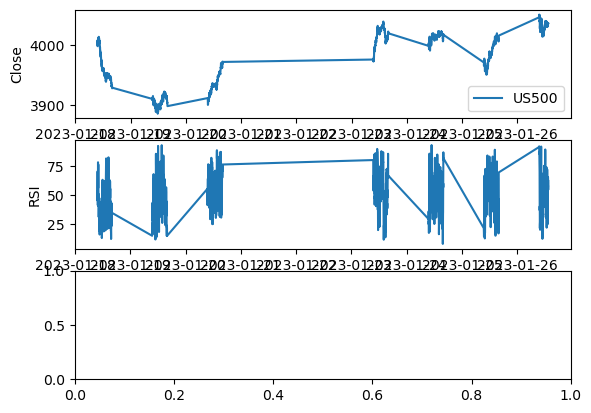

In [4]:
fig, axs = plt.subplots(ncols=1, nrows=3)

sns.lineplot(data=data[['Close']], x=data.index, y="Close", label='US500', ax=axs[0])

sns.lineplot(data=data[['RSI']], x=data.index, y='RSI', ci=None, ax=axs[1])

Train Agent

In [5]:
model.fit(X_train, y_train)

model.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Save Agent

In [6]:
joblib.dump(model, AGENTS_path / f'{SYMBOL}-agent.pkl')

['F:\\AiQuant\\models\\^GSPC-agent.pkl']